In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from activ.pipeline import score_clusters
import matplotlib.pyplot as plt
import scipy
import h5py
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as _sch
from collections import Counter
from activ import load_data

In [16]:
data = load_data()
oc_features = data.outcome_features
oc = data.outcomes
for ii,o in enumerate(oc_features):
    if 'GOSE' in o:
        print(o,ii)

GOSE_NeedAssistance3M 0
GOSE_WorkResume3M 1
GOSE_DisruptRelation3M 2
GOSE_OtherIssues3M 3
GOSE_OverallScore3M 4
GOSE_Reponder6M_Patient.alone 24
GOSE_Reponder6M_Patient.plus.relative 25
GOSE_NeedAssistance6M 26
GOSE_Travel6M 27
GOSE_SocialResume6M 28
GOSE_OtherIssues6M 29
GOSE_Epilepsy6M 30
GOSE_EpilepsyRisk6M 31
GOSE_OverallScore6M 32


In [17]:
# GOSE scores
gose_needassistance_3m = oc[:,0]
gose_workresume_3m = oc[:,1]
gose_disruptrelation_3m = oc[:,2]
gose_otherissues_3m = oc[:,3]
gose_overallscore_3m = oc[:,4]
gose_Reponder6M_Patient_alone = oc[:,24]
gose_responder6m_patientplusrel = oc[:,25]
gose_needassistance_6m = oc[:,26]
gose_Travel6M = oc[:,27]
gose_socialresume_6m = oc[:,28]
gose_otherissues_6m = oc[:,29]
gose_epilepsy_6m = oc[:,30]
gose_epilepsyrisk_6m = oc[:,31]
gose_overallscore_6m = oc[:,32]

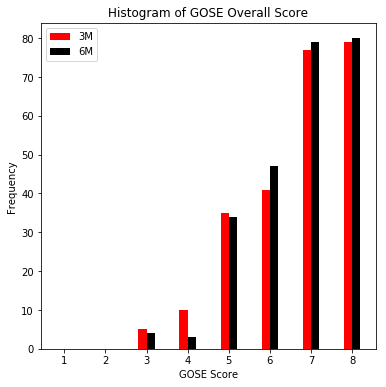

In [4]:
plt.figure(figsize=(6,6))
plt.hist([gose_overallscore_3m, gose_overallscore_6m], align='left', bins=np.arange(1,9,0.5), label=['3M','6M'], color=['red','black'])
plt.title('Histogram of GOSE Overall Score')
plt.xlabel('GOSE Score')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/hist_gose.pdf')

Text(0,0.5,'Count')

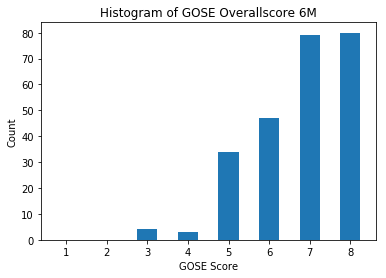

In [85]:
plt.hist(gose_overallscore_6m, align='left', bins=np.arange(1,9,0.5))
plt.title('Histogram of GOSE Overallscore 6M')
plt.xlabel('GOSE Score')
plt.ylabel('Count')

(array([ 1.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 <a list of 7 Patch objects>)

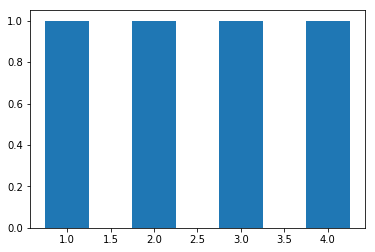

In [81]:
x = [1,2,3,4]
ticks = np.arange(1,5,0.5)
plt.hist(x, align='left', bins=ticks)

In [6]:
file = '/Users/ahyeon/Desktop/activ misc/sweep_u2-10_c2-50_i50_raw-oc-cluster_uoinmf-bm-predict/umap_clustering_sweep.h5'

In [7]:
f = h5py.File(file, 'r')

In [8]:
umap_dims = f['umap_dimensions'][:]
score = f['score'][:]
norm_score = f['norm_score'][:]
clusters = f['clusters'][:]
cluster_sizes = f['cluster_sizes'][:]

In [9]:
emb = f['umap_embeddings'][:]
scale = f['umap_embeddings_dimscale'][:][:54]

In [10]:
for dim in umap_dims:
    all_dmat = np.zeros((30381,50))
    for x in range(emb.shape[0]):
        dmat = pdist(emb[x][:,scale==dim], metric='mahalanobis')
        all_dmat[:,x] = dmat
    mean = all_dmat.mean(axis=1)
mean.shape

(30381,)

In [11]:
def calc_entropy(gose_scores):
    probs = np.array(list(Counter(gose_scores).values()))/len(gose_scores)
    return entropy(probs, base=2.0)

In [12]:
def entropy_across_clusters(cluster_sizes, data):
    values = []
    tree = _sch.linkage(mean, method='ward')
    labels = _sch.cut_tree(tree, cluster_sizes)

    for ii,c in enumerate(cluster_sizes):
        entropies = []
        for label in np.unique(labels[:,ii]):
            scores = data[labels[:,ii]==label]
            ent = calc_entropy(scores)
            entropies.append(ent)
        v = np.mean(entropies)
        values.append(v)
    return values

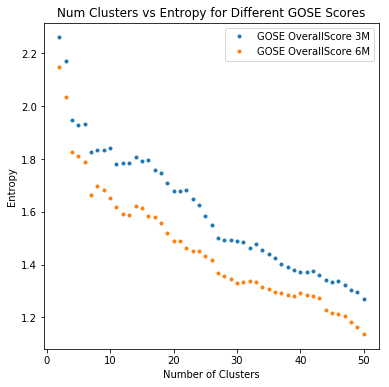

In [13]:
plt.figure(figsize=(6,6))
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_overallscore_3m), '.', label='GOSE OverallScore 3M')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_overallscore_6m), '.', label='GOSE OverallScore 6M')
plt.xlabel('Number of Clusters')
plt.ylabel('Entropy')
plt.title('Num Clusters vs Entropy for Different GOSE Scores')
plt.legend() 
plt.savefig('/Users/ahyeon/Desktop/activ misc/gose_entropy.pdf')

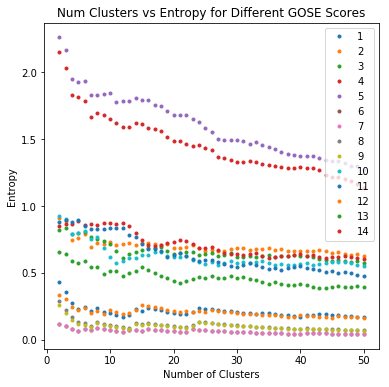

In [20]:
plt.figure(figsize=(6,6))
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_needassistance_3m), '.', label='1')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_workresume_3m), '.', label='2')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_disruptrelation_3m), '.', label='3')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_otherissues_3m), '.', label='4')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_overallscore_3m), '.', label='5')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_Reponder6M_Patient_alone), '.', label='6')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_responder6m_patientplusrel), '.', label='7')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_needassistance_6m), '.', label='8')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_Travel6M), '.', label='9')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_socialresume_6m), '.', label='10')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_otherissues_6m), '.', label='11')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_epilepsy_6m), '.', label='12')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_epilepsyrisk_6m), '.', label='13')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_overallscore_6m), '.', label='14')



plt.xlabel('Number of Clusters')
plt.ylabel('Entropy')
plt.title('Num Clusters vs Entropy for Different GOSE Scores')
plt.legend() 

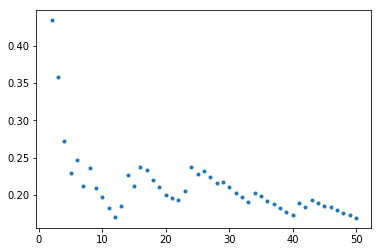

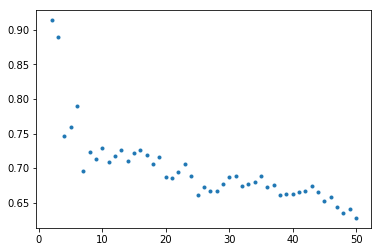

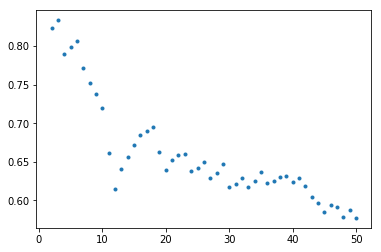

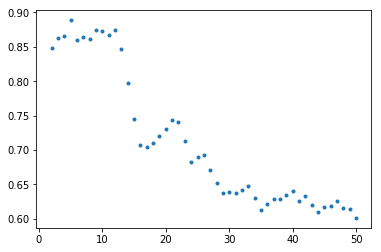

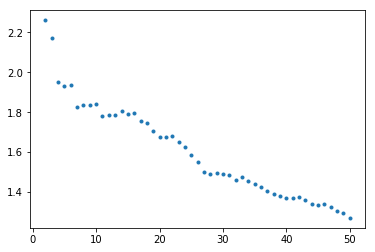

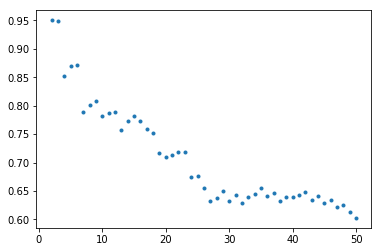

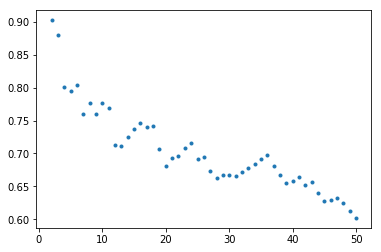

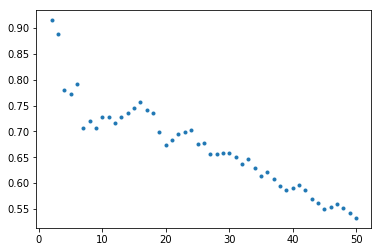

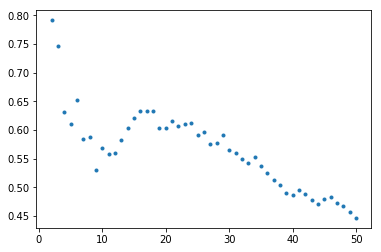

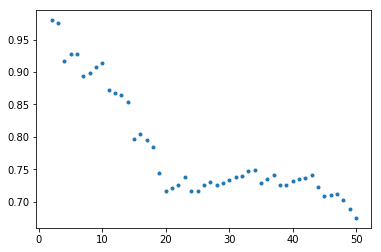

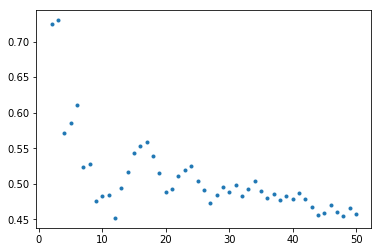

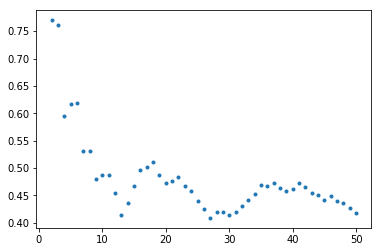

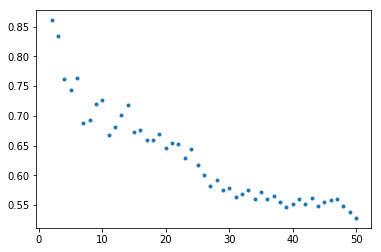

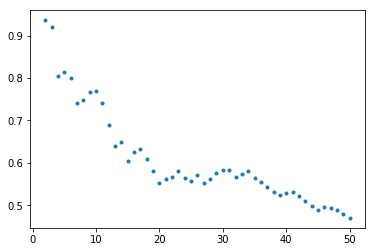

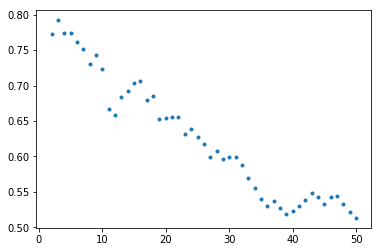

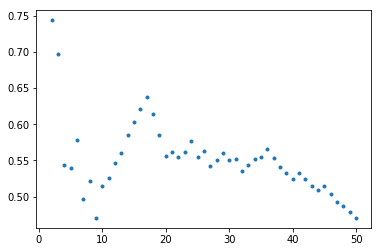

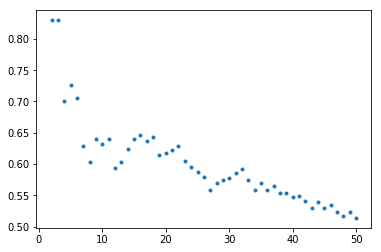

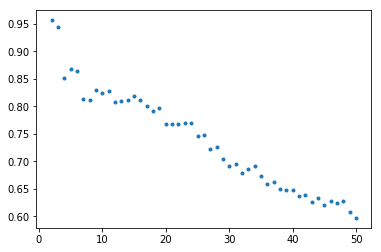

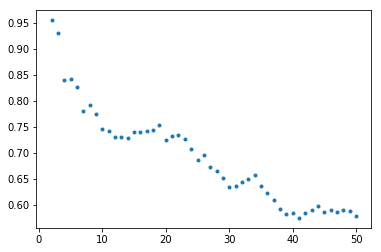

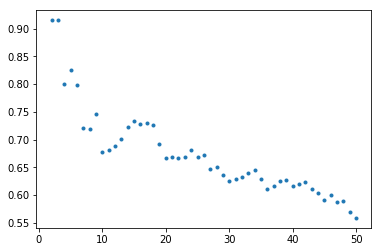

In [25]:
# top 20
for i in range(20):
    data = oc[:,i]
    plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, data), '.', label='o')
    plt.show()